<a href="https://colab.research.google.com/github/TheAmirHK/time_series_forecasting/blob/main/time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
!pip install pystan==2.19.1.1
!pip install convertdate
!pip install lunarcalendar
!pip install holidays==0.10.5
!pip install fbprophet
!pip install yfinance
import yfinance as yf
!pip install pmdarima
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from fbprophet import Prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pystan-2.19.1.1.tar.gz (16.2 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp39-cp39-linux_x86_64.whl size=61826420 sha256=f413897f73dc1638d0f9615738ab473c289ad09168e755551072e8bbcef59a2f
  Stored in directory: /root/.cache/pip/wheels/b8/36/bf/7ec7e363f796373cea3eb9ea94e83f5bbbb586d2edbf7e3417
Successfully built pystan
  Attempting uninstall: pystan
    Found existing installation: pystan 3.6.0
    Uninstalling pystan-3.6.0:
      Successfully uninstalled pystan-3.6.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement h

In [3]:
def retrieve_stock_data(stock_symbol, start_date, end_date):
    """
    Retrieves time series data for a given stock symbol and date range from Yahoo Finance API
    """
    df = yf.download(stock_symbol, start=start_date, end=end_date)
    df =  df[['Close']].rename(columns={'Close': 'value'})
    # Split data into training and test sets
    train = df.loc[:'2021-05-31']
    test = df.loc['2021-06-01':]
    return train, test

In [4]:
def create_window_data(data, window_size):
    """
    Creates a sliding window of data with a given window size
    """
    X = []
    y = []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [6]:
def scale_data(train, test):
    """
    Scales the time series data to a [0, 1] range using MinMaxScaler
    """
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    test_scaled = scaler.transform(test)
    return train_scaled, test_scaled, scaler

In [7]:
def fit_prophet_model(train, test):
    """
    Fits a Prophet model to the training data and generates forecasts for the testing set
    """
    train_prophet = train.reset_index().rename(columns={'Date': 'ds', 'value': 'y'})
    test_prophet = test.reset_index().rename(columns={'Date': 'ds', 'value': 'y'})
    model_prophet = Prophet()
    model_prophet.fit(train_prophet)
    forecast_prophet = model_prophet.predict(test_prophet[['ds']])
    return forecast_prophet['yhat'].values

In [8]:
def fit_ses_model(train, test):
    """
    Fits a Simple Exponential Smoothing (SES) model to the training data and generates forecasts for the testing set
    """
    model_ses = sm.tsa.SimpleExpSmoothing(train).fit()
    forecast_ses = model_ses.forecast(len(test))
    return forecast_ses

In [9]:
def fit_arima_model(train, test):
    """
    Fits an auto-ARIMA model to the training data and generates forecasts for the testing set
    """
    model_arima = auto_arima(train, seasonal=False, error_action='ignore', suppress_warnings=True)
    results_arima = model_arima.fit(train)
    forecast_arima = results_arima.predict(n_periods=len(test), return_conf_int=True)
    return forecast_arima[0], forecast_arima[1][:, 0], forecast_arima[1][:, 1]

In [10]:
def train_lstm_model(X_train, y_train, X_test,scaler, epochs=50, batch_size=32):
    """
    Fits a LSTM model to the training data 
    """
    # Define the LSTM model architecture
    model_lstm = Sequential()
    model_lstm.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model_lstm.add(LSTM(50))
    model_lstm.add(Dense(1))
    # Compile the model and fit it to the training data
    model_lstm.compile(optimizer='adam', loss='mean_squared_error')
    model_lstm.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    # Make predictions with the LSTM model
    y_pred_scaled_lstm = model_lstm.predict(X_test)
    print (np.shape(y_pred_scaled_lstm))
    y_pred_lstm = scaler.inverse_transform(y_pred_scaled_lstm)
    return y_pred_lstm

In [11]:
def fit_gradient_boost_model(X_train, y_train, X_test, scaler):
    
    """
    Fits a Gradient Boosting Regressor model to the training data and generates forecasts for the testing set
    """
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    estimator = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01, max_depth=10, random_state=42)
    estimator.fit(X_train, y_train)    
    # Make predictions
    y_test_pred = estimator.predict(X_test)
    
    # Reverse scaling on predictions
    y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()
    return y_test_pred

In [12]:
def plot_forecasts(train, test,y_pred_lstm, y_pred_gradient,y_pred_arima,y_pred_prophet ):
    fig, ax = plt.subplots(figsize=(18, 9))
    ax.plot(train.index, train['value'], label='Training Set')
    ax.plot(test.index, test['value'], label='Test Set')
    ax.plot(test.index[window_size:], y_pred_lstm, label='Forecast_LSTM')
    ax.plot(test.index[window_size:], y_pred_gradient, label='Forecast_GB')
    ax.plot(test.index, y_pred_arima[0], label='Forecast_ARIMA')
    #ax.fill_between(test.index, y_pred_arima[1], y_pred_arima[2], alpha=0.2)
    ax.plot(test.index, y_pred_prophet, label='Forecast_Prophet')
    ax.set_xlabel('Date')
    ax.set_ylabel('Closing Price')
    ax.set_title('Forecast of Stock Price')
    ax.legend()
    plt.show(block=False)

[*********************100%***********************]  1 of 1 completed


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency informa

Epoch 1/50
86/86 [==============================] - 5s 11ms/step - loss: 0.0046
Epoch 2/50
86/86 [==============================] - 1s 11ms/step - loss: 2.5563e-04
Epoch 3/50
86/86 [==============================] - 1s 15ms/step - loss: 2.0647e-04
Epoch 4/50
86/86 [==============================] - 2s 18ms/step - loss: 2.0872e-04
Epoch 5/50
86/86 [==============================] - 1s 16ms/step - loss: 2.5618e-04
Epoch 6/50
86/86 [==============================] - 1s 11ms/step - loss: 2.0731e-04
Epoch 7/50
86/86 [==============================] - 1s 11ms/step - loss: 2.1173e-04
Epoch 8/50
86/86 [==============================] - 1s 11ms/step - loss: 2.0113e-04
Epoch 9/50
86/86 [==============================] - 1s 11ms/step - loss: 2.2735e-04
Epoch 10/50
86/86 [==============================] - 1s 12ms/step - loss: 1.8897e-04
Epoch 11/50
86/86 [==============================] - 1s 11ms/step - loss: 2.0074e-04
Epoch 12/50
86/86 [==============================] - 1s 11ms/step - loss: 2.02

/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[*********************100%***********************]  1 of 1 completed


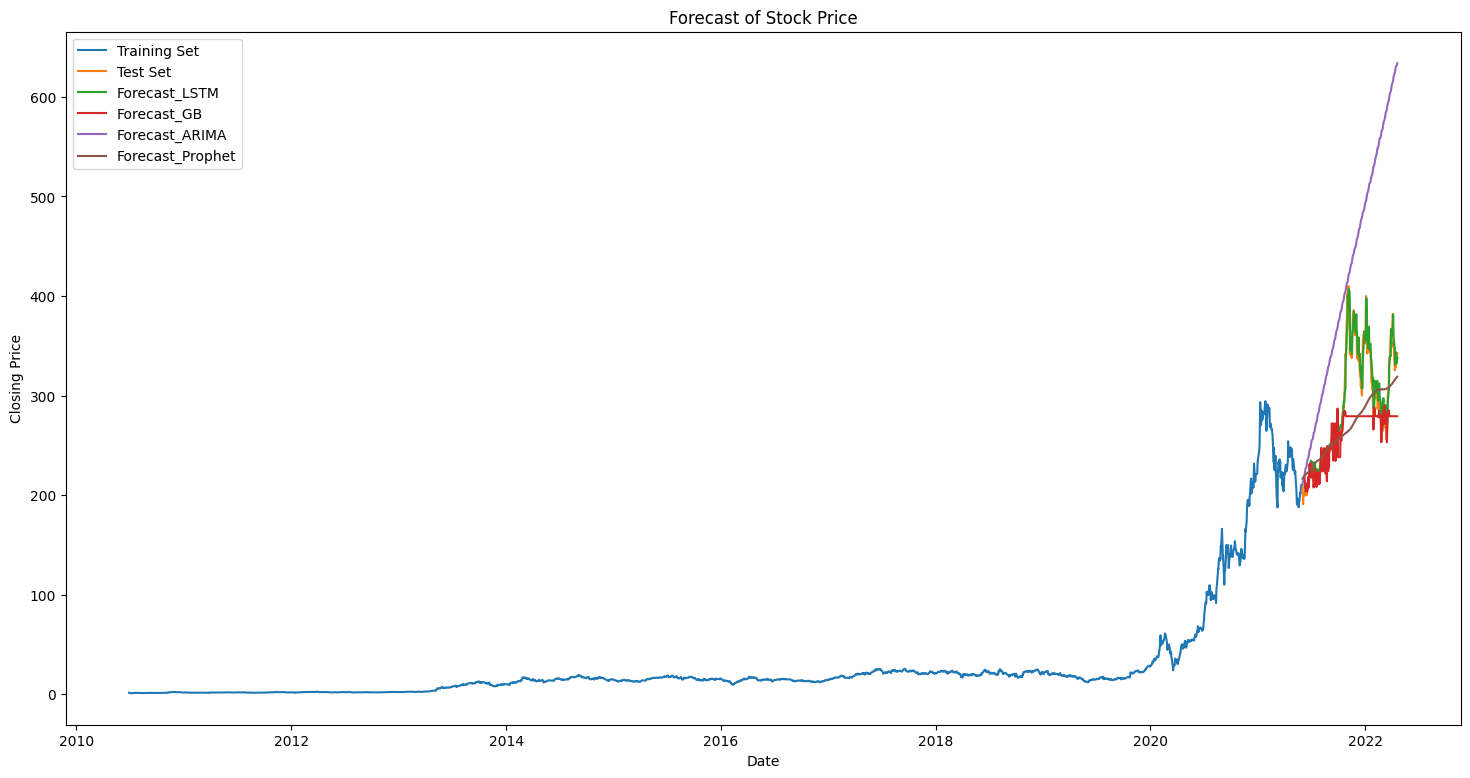

ValueError: ignored

In [13]:
if __name__ == '__main__':
    # Retrieve the stock data
    stock_symbol = 'TSLA' ## AAPL  Apple or TSLA  Tesla
    start_date = '2010-01-01'
    end_date = '2022-04-20'
    window_size = 5
    train, test = retrieve_stock_data (stock_symbol, start_date, end_date)
    
    train_scaled, test_scaled, scaler = scale_data(train, test)
    
    X_train, y_train = create_window_data(train_scaled, window_size)
    X_test, y_test = create_window_data(test_scaled, window_size)
    
    y_pred_prophet = fit_prophet_model(train, test)
    y_pred_ses = fit_ses_model(train, test)
    y_pred_arima = fit_arima_model(train, test)
    y_pred_lstm = train_lstm_model(X_train, y_train,X_test, scaler)
    y_pred_gradient = fit_gradient_boost_model(X_train, y_train, X_test, scaler)
    train, test = retrieve_stock_data(stock_symbol, start_date, end_date)

    # Plot the forecasts
    plot_forecasts(train, test,y_pred_lstm, y_pred_gradient,y_pred_arima,y_pred_prophet )
    mae_ses = np.mean(np.abs(y_pred_ses.values[window_size:] - test.values[window_size:]))
    mae_arima = np.mean(np.abs(y_pred_arima[0] - test.values[window_size:]))
    mae_prophet = np.mean(np.abs(y_pred_prophet - test.values[window_size:]))
    mae_gradient = np.mean(np.abs(y_pred_gradient - test.values[window_size:]))
    mae_lstm = np.mean(np.abs(y_pred_lstm - test.values[window_size:]))
    ## In[] Print MAE for each model and Plot the forecasts along with the test set
    print('LSTM MAE:', mae_lstm)
    print('SES MAE:', mae_ses)
    print('ARIMA MAE:', mae_arima)
    print('Prophet MAE:', mae_prophet)
    print('gradient MAE:', mae_gradient)